In [2]:
# load packages

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')
import sys
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display


In [148]:
# Further Markdown settings

# load libraries and set plot parameters



In [3]:
# specifying the path

import os
path = os.chdir(r'C:\Users\Mohamed Ahmed Warsam\Desktop\PythonScripts')
datapath1 = 'ts_modelling1.xlsx'


In [4]:
# import the data

data = pd.read_excel(datapath1, sheetname=0, index_col='Created')

In [13]:
# view data

display(data.head(10))
display(data.tail(10))

display(data.info())

In [14]:
# turning several columns into categories

data['Category'] = data['Category'].astype('category')
data['Priority'] = data['Priority'].astype('category')
data['Incident state'] = data['Incident state'].astype('category')
data['Urgency'] = data['Urgency'].astype('category')
data['Impact'] = data['Impact'].astype('category')


In [15]:
# checking change

data.info()
data.Priority.value_counts()

# Ticket Volume Forecasting Project - Pearson by Mohamed Warsame

This mini-project aims to provide ticket volume forecast over December 2016 and February 2017, on the basis of historical ticket volume recorded between July 2014 and November 2016. It is important to inspect and evaluate the dataset before delving into the modelling process. The underlying dataset has 7 columns in total, the date range starting on 2014-07-01 19:16:00 and ending on 2016-11-21 19:45:00. There are 25479 tickets recorded during that time period.

## Exploratory Data Analysis

The figure below provides a visual impression of the historical ticket volume (total) over the entire date range covered by the dataset. As can be seen, the series initially exhibits a moderate linear growth trend and roughly gains 5000 tickets every six months. However, there is an unprecedented jump in total ticket count occurring at the end of August 2016. The count of tickets gains over 1000 additional tickets on a single day. This event would be referred to as a structural break, or exogenous shock to the system in the terminology of statistical literature. The shape of the line also changes, displaying characteristics of a concave mathematical function with a very steep slope, rather than the moderate linear growth trend prior to that. To further examine this, we can zoom into the figure by only selecting a subset of the overall date range.

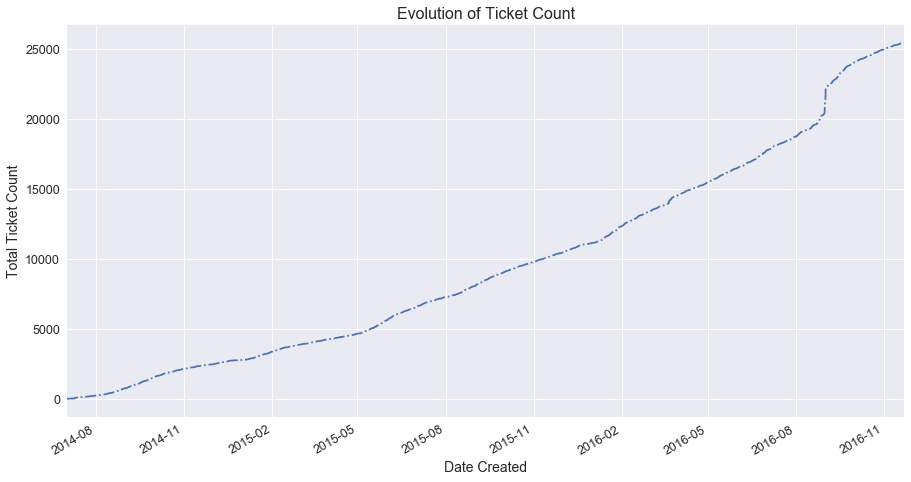

In [12]:
# explore the time series as visualisation
# Sample goes from July 2014 to November 2016
sns.set(font_scale = 1.25)


y = data['Number']

y.plot(linestyle='-.', figsize=(15, 8))
plt.xlabel('Date Created', fontsize=14)
plt.ylabel('Total Ticket Count', fontsize=14)
plt.title('Evolution of Ticket Count', fontsize=16)
plt.show()

fig = plt.figure()
fig.savefig('ETC.png', dpi=100)
plt.close(fig)


From the zoomed in perspective we can see that the extreme outlier day was the last day of August, 2016-08-31, after which the trend seems to indicate that roughly 1 thousand tickets come in every month. Contingent upon the hypothesis that this trend continues into the forecasting period this task aims to predict, we can already infer that total ticket count will reach close to 30,000 tickets by February 2017. However, further statistical analysis is required to establish the robustness of this rough estimate inferred from basic exploratory data analysis.

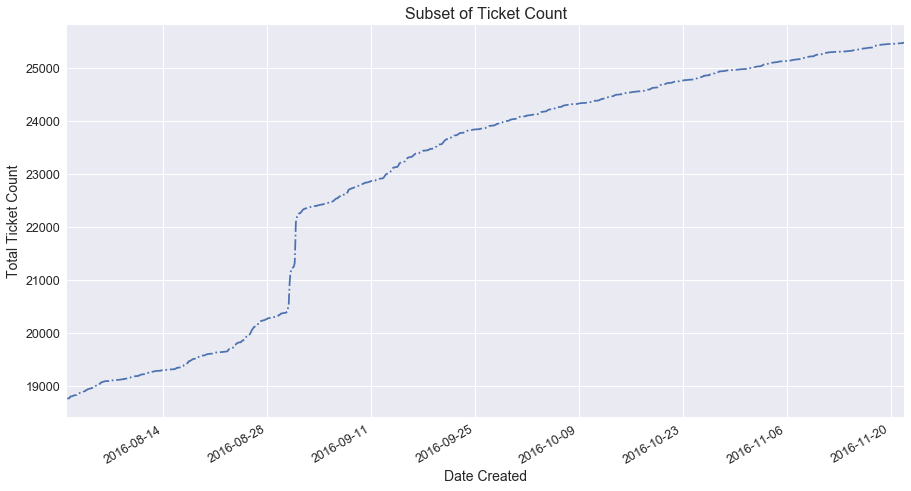

In [16]:
# Subset of ticket count of outburst

doubling = data.loc['2016-08-01': '2016-11-21',:]

y1 = doubling['Number']

y1.plot(linestyle='-.', figsize=(15, 8))
plt.xlabel('Date Created', fontsize=14)
plt.ylabel('Total Ticket Count', fontsize=14)
plt.title('Subset of Ticket Count', fontsize=16)
plt.show()


The following horizontal bar chart shows us the exact date of the outlier observed on the prior visualisations. Identified to be the last day of August, we can see that close to 1400 tickets have been recorded in that day alone. The prior day, 30th of August, 2016, also recorded an abnormally high number of tickets. To conclude on this point, those two days alone contributed close to 2000 tickets, a figure that is usually only reached over the course of several months. Perhaps, a system outage, or other technical problem with the overall technological infrastructure of Pearson failed around that time. In fact, after taking a closer look at that week, it appears that a ticket raised at around 11pm on the 29th August marked with the highest priority level 'critical' may have triggered the abnormally high ticket count of the following day. This supports my suspicion that a database, or systems related issue may have resulted in an outage of the entire technology infrastructure, severely limiting the actions of users. 

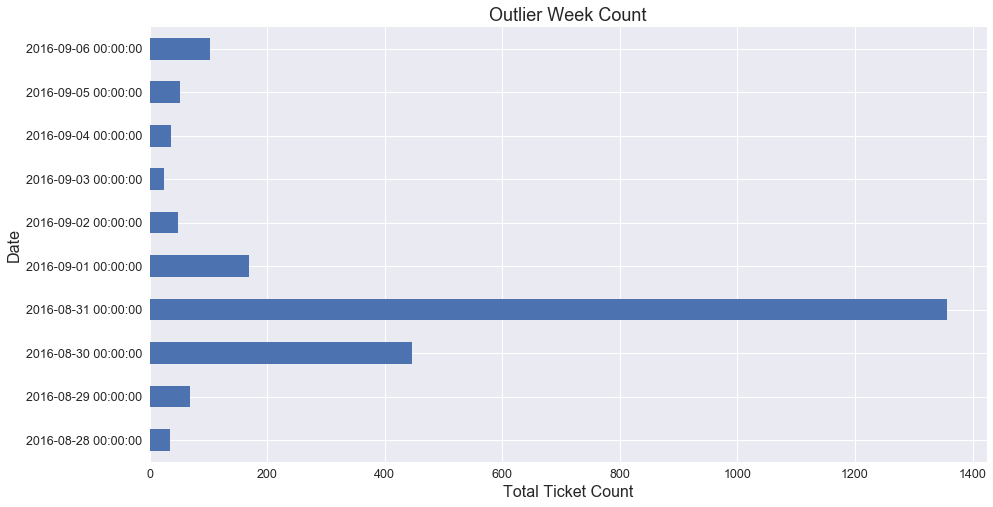

In [17]:
# Showing the day 
sns.set(font_scale = 1.25)
outlier = data.loc['2016-08-28':'2016-09-06','Number'].resample('D').count()

#data1 = data.loc['2016-08-28':'2016-09-06',:]

outlier.plot(x=outlier.index, y=outlier, kind='barh', figsize=(15, 8))
plt.xlabel('Total Ticket Count', fontsize=16)
plt.ylabel('Date', fontsize=16)
plt.title('Outlier Week Count', fontsize=18)
plt.show()


In order not to make erroneous decisions in the modelling process that follows, we need to exclude those two outliers from the sample. The line plot below shows the total ticket count grouped by day and not just the cumulative count of the 'Number' column in the dataset. It also perfectly illustrates the issue of outliers in forecasting, as they introduce a scaling problem of the axes and also misinform the statistical model, since they are not representative of the overall behaviour of the data generating process. With over 200 tickets, there is another day in March 2016 that has a value which is extremely different from neighbouring observations. For now, we can treat those three days that exhibit an abnormally high number of tickets as random bursts. The subsequent figure will show how the scales of the vertical axis will change after removing the extreme value in March and also the two more recent outliers.

In [18]:
# potential idea - I can use .resample() to resample by hour and count .mean to get average ticket volume

yd = data.loc[:,'Number'].resample('D').count()

#display(yd.head(20))

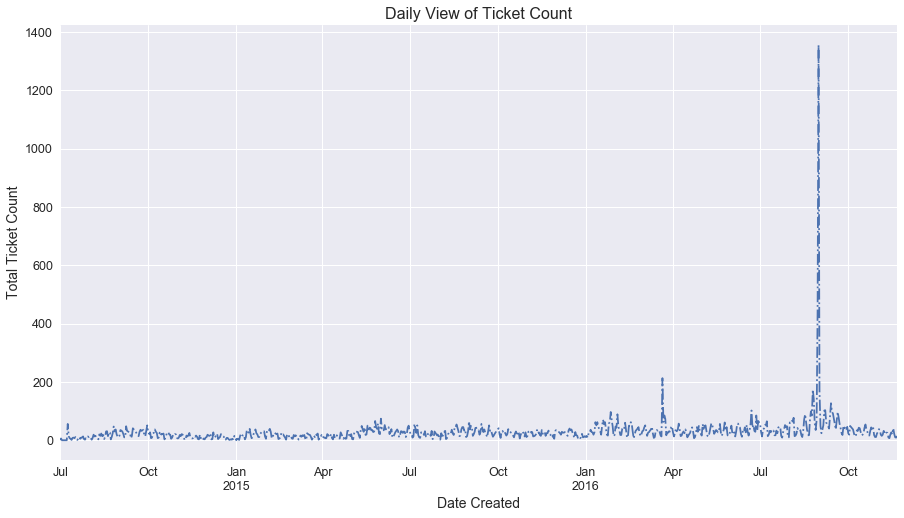

In [19]:
# plot daily count

yd.plot(linestyle='-.', figsize=(15, 8))
plt.xlabel('Date Created', fontsize=14)
plt.ylabel('Total Ticket Count', fontsize=14)
plt.title('Daily View of Ticket Count', fontsize=16)
plt.show()


In [20]:
# import changed excel
datapath2 = 'ts_modelling2.xlsx'

newdata = pd.read_excel(datapath2, sheetname=0, index_col='Created')

After removing those two outlier days, the scaling of our vertical axis changed significantly. The number of tickets coming in on a daily basis now range between 0 and 175, reaching this boundary only once in September 2016, when not taking into account those three outlier days that have been removed. The overall average for the entire date range gives us a figure of 26 tickets per day, again, this mean value does not take the 3 outlier days into consideration. A striking insight that one can derive from analysing the figure below is that the series becomes more volatile from January 2016 onwards, with a much larger variance and also containing more extreme values. In conclusion, the trend of daily ticket volume was more stable in 2015 than in 2016 and these characteristics indicate that a seasonal ARIMA (Auto-regressive Integrated Moving-average) model seems to be most suitable for the forecasting task. This would enable us to account for seasonal variation, the trend factor and the random noise component which is inherent in the underlying dataset.

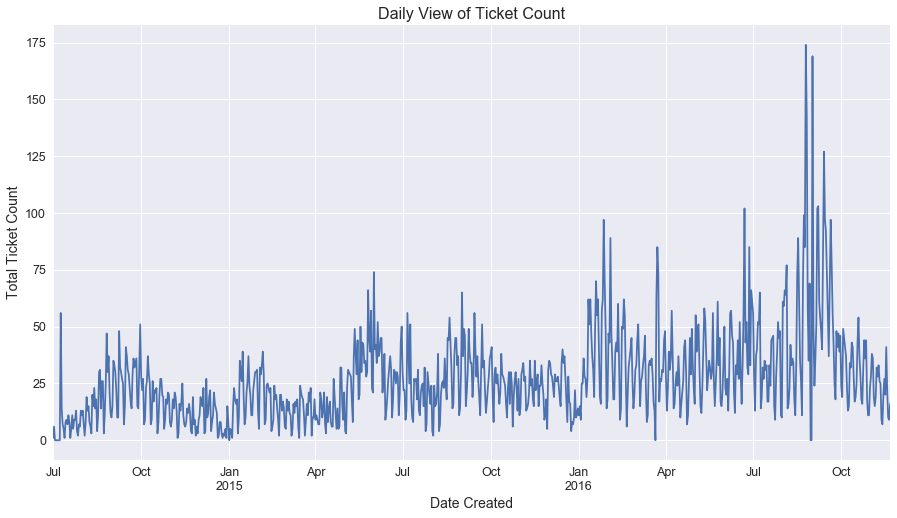

In [21]:
#  y2 

y_ = newdata.loc[:,'Number'].resample('D').count()



y_.plot(linestyle='-', figsize=(15, 8))

#y_mean = [np.mean(y_)]*len(newdata.index)

plt.xlabel('Date Created', fontsize=14)
plt.ylabel('Total Ticket Count', fontsize=14)
plt.title('Daily View of Ticket Count', fontsize=16)
plt.show()


## Time Series Methodology and Analysis

The seasonal ARIMA model incorporates both non-seasonal and seasonal factors in a multiplicative model.  One shorthand notation for the model is: $ARIMA(p, d, q) × (P, D, Q)S$  with with $p$ = non-seasonal AR order, $d$ = non-seasonal differencing, $q$ = non-seasonal MA order, $P$ = seasonal AR order, $D$ = seasonal differencing, $Q$ = seasonal MA order, and $S$ = time span of repeating seasonal pattern. 

The regression output below shows the implementation of a **seasonal ARIMA** model, which suggests that all the selected parameters are statistically significant and of large magnitude, i.e., explaining the underlying time series. The **coef** column illustrates the weighting (i.e. importance) of each parameter and shows how each one affects daily ticket volume. The **P>|z|** column shows us the magnitude of each feature weight. Here, each weight has a **p-value** lower than 0.05, enabling us to infer that we can keep all of the parameters in our model.

In [22]:
# Fitting the model - ARIMA(1, 1, 1)x(1, 1, 1, 12)12

mod = sm.tsa.statespace.SARIMAX(y_,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3893      0.022     17.335      0.000       0.345       0.433
ma.L1         -1.0893      0.015    -71.664      0.000      -1.119      -1.059
ar.S.L12      -0.0720      0.022     -3.293      0.001      -0.115      -0.029
ma.S.L12      -1.0232      0.019    -53.143      0.000      -1.061      -0.985
sigma2       179.7996      9.982     18.013      0.000     160.236     199.363


However, when estimating and fitting seasonal ARIMA models, it is crucial to also compute model diagnostics. This ensures that none of the assumptions made by the statistical algorithm have been violated. The plot_diagnostics object enables us to quickly visualise model diagnostics and investigate for any unusual patterns.

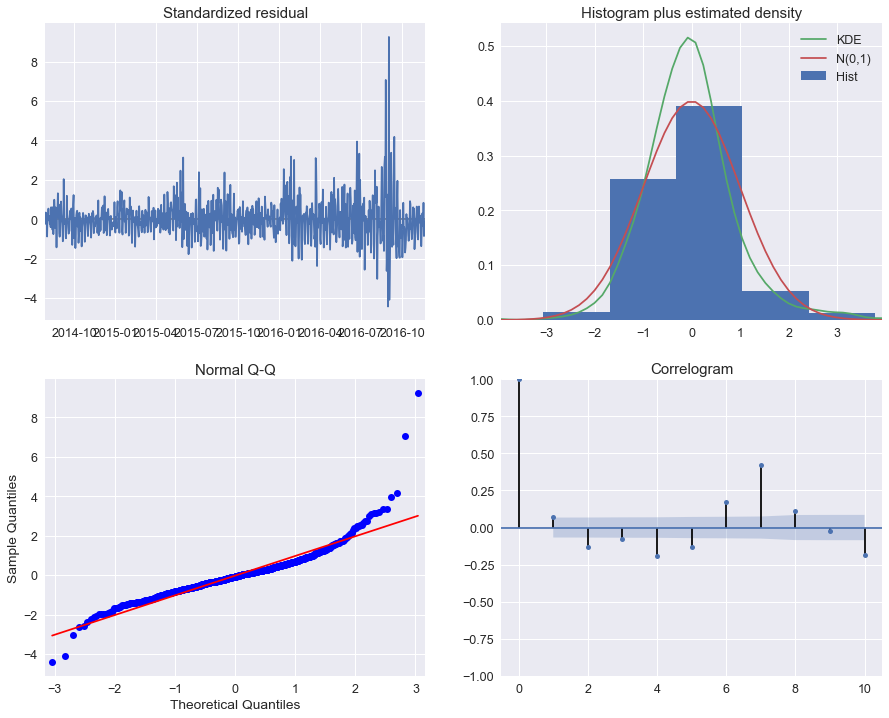

In [23]:
# Plotting model diagnostics

results.plot_diagnostics(figsize=(15, 12))
plt.show()

The main point of concern for this modelling exercise is to verify whether the residuals of the seasonal ARIMA model are uncorrelated and normally distributed with zero-mean. If the model does not satisfy these properties, it simply means that it can be enhanced by additional hyperparameter tuning, i.e., tweaking the estimated equation such that our model achieves the desired statistical properties. Unfortunately, engaging in such painstaking manual steps is beyond the scope of this analysis. In the above case, our model diagnostics plots suggest that the residuals are approximately normally distributed. \begin{enumerate}

\item In the top right plot, we see that the green **KDE** line roughly follows the **N(0,1)** line (**where N(0,1)**) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 

\item The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with **N(0, 1)**. Again, this is a strong indication that the model residuals are approximately normally distributed.

\item The residuals over time (top left plot) do not exhibit any obvious seasonality and appear to be white noise. The only cause for concern is the high variance towards the end of 2016. Also, the autocorrelation (i.e. correlogram) plot on the bottom right, shows that the time series residuals exhibit _some_ correlation with lagged versions of itself. This implies that there is a presence of autocorrelation.
\end{enumerate}
.

Taking these insights into consideration leads us to conclude that our model can indeed produce a satisfactory fit that could enable us to better understand our time series data and forecast future values. Another conclusion implicit in the observations elaborated on above is that 2016 is unlike 2015. Thus, it would be better to only feed the values of 2016 into our forecasting model.

### Validating the Model

As the discussion above has shown, we have obtained a rigorous methodology of a statistical model for our time series data of ticket volume that can now be used to produce forecasts. The first step of validating our seasonal ARIMA model is to compare the predicted values to the real values of the time series, which will aid us in understanding the accuracy of the forecast to come. The below plot shows the observed data of total ticket volume (blue colour) compared to our one-step ahead forecast (red colour) that was produced by the selected seasonal ARIMA methodology. The shaded area represents confidence intervals that provide us with a measure of certainty. Owing to the strong variability of the data for 2016, the confidence bounds are quite wide. Overall, the model forecasts align with the real observed values very well.

In [24]:
# comparing forecast values with actual values

pred = results.get_prediction(start=pd.to_datetime('01/01/2016'), dynamic=False)
pred_ci = pred.conf_int()

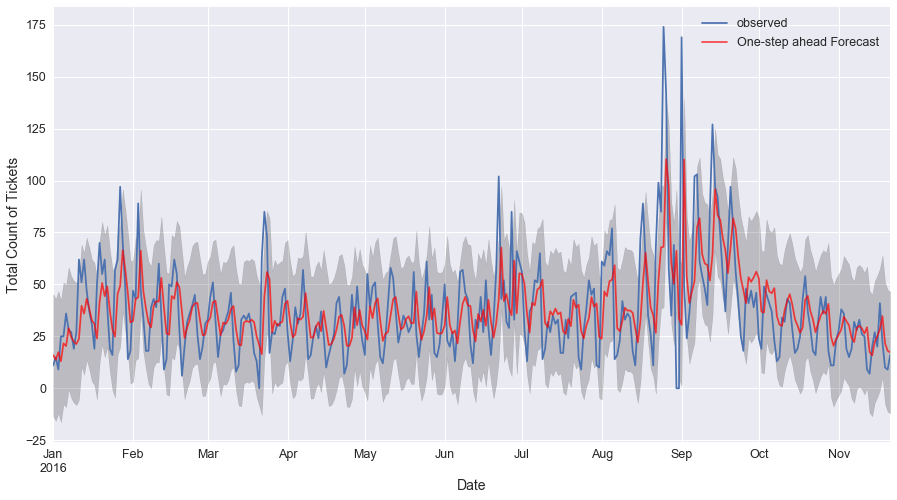

In [25]:
# Plotting original versus forecast

ax = y_['01/01/2016':].plot(label='observed', figsize=(15, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='r', alpha=.7, figsize=(15, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Count of Tickets', fontsize=14)
plt.legend()

plt.show()


It is also useful to compute a measure of the accuracy of our forecasts. We will utilise the MSE (Mean Squared Error), which summarises the average error of the forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean. As can be seen below, the MSE of our one-step ahead forecasts yields a value of 422.45, which is quite high as it should be close to 0. An MSE of 0 would mean that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible. One reason for this high value of MSE is that our dataset for 2016 exhibits a very high variability, as could be seen by the confidence intervals in the graph above. In conclusion, this forecasting task may require a more advanced modelling methodology to reduce the MSE further.

In [26]:
# computing the MSE

y_forecasted = pred.predicted_mean
y_truth = y_['01/01/2016':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecast is 422.45


### Forecast for December-February 2017

As can be seen from the forecast for December, January and February, the seasonal ARIMA model provided us with an estimate of roughly 20-30 tickets per day, fluctuating around an average of 20 tickets. This is simply an extension of the lower daily average that started to decrease in September 2016. Prior visualisations have shown that there is a decreasing trend visible from the latter part of the second half of 2016. This feature is inherent in any seasonal ARIMA model, which picks up on the nearest seasonal patterns and adjusts its forecast accordingly. Another noticable characteristic of the forecast is that it exhibits less variability than the actual series, something that a more enhanced methodology could improve on. Furthermore, there are many other variables that impact ticket volume, such as: (1) the number of users that utilise a given software infrastructure, (2) the average number of bugs, and (3) the average number of technical staff that develop and maintain a given software infrastructure. Obtaining data on the number of users per day and hour of the day would remove a substantial amount of uncertainty from the errors and enhance the modelling results further. 

In [27]:
# Forecast 99 days into the future, last date of sample is 21/11/2016

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=99)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

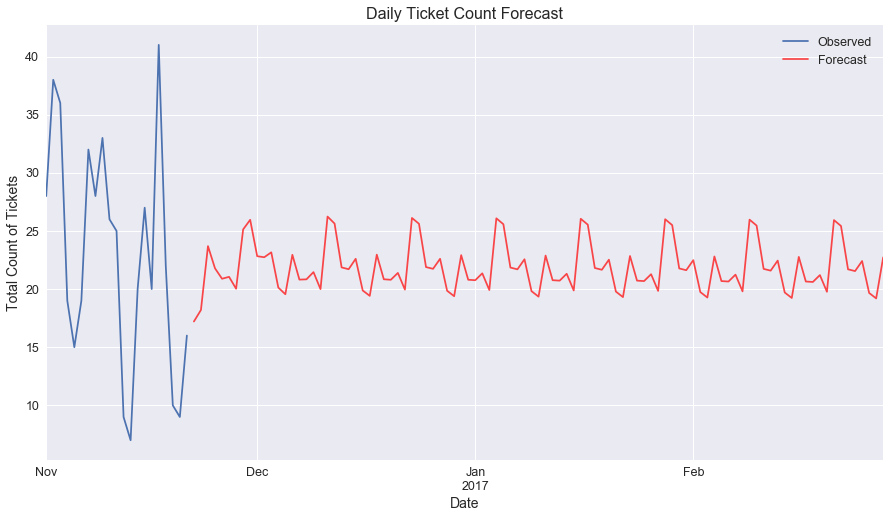

In [28]:
# plot forecast
sns.set(font_scale = 1.25)

ax = y_['11/01/2016':].plot(label='Observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='r', alpha=.7, figsize=(15, 8))


ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Count of Tickets', fontsize=14)
plt.legend()
plt.title('Daily Ticket Count Forecast', fontsize=16)
plt.show()


In [146]:
# Time Series Modelling, DEFINING THE ARIMA TERMS

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



In [150]:
# Hyper Parameter tuning for our SARIMA model
# chosen model ARIMA(1, 1, 1)x(1, 1, 1, 12)12


import statsmodels.api as sm

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
            


In [151]:
# calculating the mean of  y_

y_mean = np.mean(y_)

print(y_mean)

In [74]:
# turning the index into a list

y_mean = [np.mean(y_)]*len(newdata.index)

In [ ]:
# investigating the difference in the number of rows

#print(len(data))
#print(len(newdata))

In [ ]:
# maybe you can count the number of rows (category) using the .count() on resample
# there must be a method
# the number of users that utilise a given software infrastructure
# the average number of bugs
# the average number of technical staff that develop and maintain a given software infrastructure
# Section 1 Exploratory data analysis
# Section 2 Methodology of modelling
# Section 3 Results and insights

In [ ]:
# Characterize the growth trend and try to annotate the jump

In [ ]:
# slice the index to further investigate the jump in ticket volume

In [ ]:
# dropping outliers

#start_remove = '2016-08-30'
#end_remove = '2016-08-31'

#dropThis = data.loc['2016-08-30':'2016-08-31']

# newdata = data.drop(data.index[['2016-08-30','2016-08-31']])

#newdata1 = data[~data.index.isin(dropThis)]
